In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.56)
import gc

import os, sys, random, math

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm
import itertools
from sklearn import preprocessing
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix
import lightgbm as lgb

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [3]:
%%time

print('Loading data...')

train = pd.read_csv('E-Sun_Credit_Card_Fraud_Data/train.csv', index_col='txkey')#index_col='txkey'
print('\tSuccessfully loaded train!')

test = pd.read_csv('E-Sun_Credit_Card_Fraud_Data/test.csv', index_col='txkey')#index_col='txkey'
print('\tSuccessfully loaded train!')

print('Data was successfully loaded!\n')

Loading data...
	Successfully loaded train!
	Successfully loaded train!
Data was successfully loaded!

Wall time: 5.67 s


In [4]:
def date_time_split(dataframe):
    dataframe['locdt_M'] = dataframe['locdt'].map({1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,10:1,11:1,12:1,13:1,14:1,15:1,
                                                   16:1,17:1,18:1,19:1,20:1,21:1,22:1,23:1,24:1,25:1,26:1,27:1,28:1,29:1,30:1,31:1,
                                                   32:2,33:2,34:2,35:2,36:2,37:2,38:2,39:2,40:2,41:2,42:2,43:2,44:2,45:2,
                                                   46:2,47:2,48:2,49:2,50:2,51:2,52:2,53:2,54:2,55:2,56:2,57:2,58:2,59:2,60:2,61:2,
                                                   62:3,63:3,64:3,65:3,66:3,67:3,68:3,69:3,70:3,71:3,72:3,73:3,74:3,75:3,
                                                   76:3,77:3,78:3,79:3,80:3,81:3,82:3,83:3,84:3,85:3,86:3,87:3,88:3,89:3,90:3,91:3,92:3,
                                                   93:4,94:4,95:4,96:4,97:4,98:4,99:4,100:4,101:4,102:4,103:4,104:4,105:4,106:4,107:4,
                                                   108:4,109:4,110:4,111:4,112:4,113:4,114:4,115:4,116:4,117:4,118:4,119:4,120:4})
    
    dataframe['locdt_W'] = dataframe['locdt'].map({1:1,2:1,3:1,4:1,5:1,6:1,7:1,
                                                   8:2,9:2,10:2,11:2,12:2,13:2,14:2,
                                                   15:3,16:3,17:3,18:3,19:3,20:3,21:3,
                                                   22:4,23:4,24:4,25:4,26:4,27:4,28:4,
                                                   29:5,30:5,31:5,32:5,33:5,34:5,35:5,
                                                   36:6,37:6,38:6,39:6,40:6,41:6,42:6,
                                                   43:7,44:7,45:7,46:7,47:7,48:7,49:7,
                                                   50:8,51:8,52:8,53:8,54:8,55:8,56:8,
                                                   57:9,58:9,59:9,60:9,61:9,62:9,63:9,
                                                   64:10,65:10,66:10,67:10,68:10,69:10,70:10,
                                                   71:11,72:11,73:11,74:11,75:11,76:11,77:11,
                                                   78:12,79:12,80:12,81:12,82:12,83:12,84:12,
                                                   85:13,86:13,87:13,88:13,89:13,90:13,91:13,
                                                   92:14,93:14,94:14,95:14,96:14,97:14,98:14,
                                                   99:15,100:15,101:15,102:15,103:15,104:15,105:15,
                                                   106:16,107:16,108:16,109:16,110:16,111:16,112:16,
                                                   113:17,114:17,115:17,116:17,117:17,118:17,119:17,
                                                   120:18})
    
    dataframe['loct_hour'] = (dataframe['loctm']//10000).astype(int)
    gc.collect()
    
    return dataframe

train = date_time_split(train)
test = date_time_split(test)

In [5]:
cols = list(train.columns)
cols.remove('fraud_ind')
for col in cols:
    temp_train = train.copy()
    temp_train.reset_index(inplace=True)
    temp_test = test.copy()
    temp_test.reset_index(inplace=True)
    
    temp_train.drop_duplicates(col,keep='first',inplace=True)
    temp_test.drop_duplicates(col,keep='first',inplace=True)
    
    temp_train['check'] = np.where(temp_train[col].isin(temp_test[col]), 1, 0)
    temp_test['check']  = np.where(temp_test[col].isin(temp_train[col]), 1, 0)
    
    percent = len(temp_train[temp_train['check']==1]) / len(temp_test)
    print(f'col: {col} ')
    print(f'percent:  {percent}')

del temp_train, temp_test

col: acqic 
percent:  0.7825506937033084
col: bacno 
percent:  0.04399499289722781
col: cano 
percent:  0.04334853930513317
col: conam 
percent:  0.5820120711761578
col: contp 
percent:  1.0
col: csmcu 
percent:  0.9298245614035088
col: ecfg 
percent:  1.0
col: etymd 
percent:  1.0
col: flbmk 
percent:  1.0
col: flg_3dsmk 
percent:  1.0
col: hcefg 
percent:  0.9
col: insfg 
percent:  1.0
col: iterm 
percent:  1.0
col: locdt 
percent:  0.0
col: loctm 
percent:  0.9902672516952533
col: mcc 
percent:  0.9301075268817204
col: mchno 
percent:  0.7040284828904859
col: ovrlt 
percent:  1.0
col: scity 
percent:  0.6678333916695834
col: stocn 
percent:  0.9310344827586207
col: stscd 
percent:  1.0
col: locdt_M 
percent:  0.5
col: locdt_W 
percent:  0.16666666666666666
col: loct_hour 
percent:  1.0


In [6]:
class BetaEncoder(object):
        
    def __init__(self, group):
        
        self.group = group
        self.stats = None
        
    # get counts from df
    def fit(self, df, target_col):
        self.prior_mean = np.mean(df[target_col])
        stats = df[[target_col, self.group]].groupby(self.group)
        stats = stats.agg(['sum', 'count'])[target_col]    
        stats.rename(columns={'sum': 'n', 'count': 'N'}, inplace=True)
        stats.reset_index(level=0, inplace=True)           
        self.stats = stats
        
    # extract posterior statistics
    def transform(self, df, stat_type, N_min=1):
        
        df_stats = pd.merge(df[[self.group]], self.stats, how='left')
        n = df_stats['n'].copy()
        N = df_stats['N'].copy()
        
        # fill in missing
        nan_indexs = np.isnan(n)
        n[nan_indexs] = self.prior_mean
        N[nan_indexs] = 1.0
        
        # prior parameters
        N_prior = np.maximum(N_min-N, 0)
        alpha_prior = self.prior_mean*N_prior
        beta_prior = (1-self.prior_mean)*N_prior
        
        # posterior parameters
        alpha = alpha_prior + n
        beta =  beta_prior + N-n
        
        # calculate statistics
        if stat_type=='mean':
            num = alpha
            dem = alpha+beta
                    
        elif stat_type=='mode':
            num = alpha-1
            dem = alpha+beta-2
            
        elif stat_type=='median':
            num = alpha-1/3
            dem = alpha+beta-2/3
        
        elif stat_type=='var':
            num = alpha*beta
            dem = (alpha+beta)**2*(alpha+beta+1)
                    
        elif stat_type=='skewness':
            num = 2*(beta-alpha)*np.sqrt(alpha+beta+1)
            dem = (alpha+beta+2)*np.sqrt(alpha*beta)

        elif stat_type=='kurtosis':
            num = 6*(alpha-beta)**2*(alpha+beta+1) - alpha*beta*(alpha+beta+2)
            dem = alpha*beta*(alpha+beta+2)*(alpha+beta+3)
            
        # replace missing
        value = num/dem
        value[np.isnan(value)] = np.nanmedian(value)
        return value

In [ ]:
#train['flbmk'] = train['flbmk'].fillna('Nan')
#train['flg_3dsmk'] = train['flg_3dsmk'].fillna('Nan')

#train['flbmk'] = train['flbmk'].fillna(train['flbmk'].mode()[0])
#train['flg_3dsmk'] = train['flg_3dsmk'].fillna(train['flg_3dsmk'].mode()[0])

In [7]:
#train['scity'] = train['stocn'].astype(str)+'_'+train['scity'].astype(str)
#test['scity'] = test['stocn'].astype(str)+'_'+test['scity'].astype(str)
train['txn_info'] = train['ecfg'].astype(str)+train['flg_3dsmk'].astype(str)+train['flbmk'].astype(str)
test['txn_info'] = test['ecfg'].astype(str)+test['flg_3dsmk'].astype(str)+test['flbmk'].astype(str)

cat_columns = ['ecfg','flbmk','flg_3dsmk','insfg','ovrlt','txn_info']

for col in cat_columns:
    train[col] = train[col].fillna('unseen_before_label')
    test[col]  = test[col].fillna('unseen_before_label')
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col]) + list(test[col]))
    train[col] = lbl.transform(train[col])
    test[col]  = lbl.transform(test[col])

train.fillna(-999,inplace = True)
test.fillna(-999,inplace = True)

In [8]:
# check amount
train['conam_check'] = np.where(train['conam'].isin(test['conam']), 1, 0)
test['conam_check']  = np.where(test['conam'].isin(train['conam']), 1, 0)

# check cano
train['cano_check'] = np.where(train['cano'].isin(test['cano']), 1, 0)
test['cano_check']  = np.where(test['cano'].isin(train['cano']), 1, 0)

In [9]:
train_len = len(train)
feq_cols = ['mchno','stocn','csmcu','etymd','stscd','txn_info',]
for col in feq_cols:
    train_test_all = pd.concat([train[['cano','conam',col]],test[['cano','conam',col]]]) 
    
    new_col_name = 'cano_'+col+'_fq'
    train_test_all[new_col_name] = train_test_all.groupby(['cano',col])['conam'].transform('count')
    train[new_col_name] = train_test_all[:train_len][new_col_name].tolist()
    test[new_col_name] = train_test_all[train_len:][new_col_name].tolist()
    
    print("'"+new_col_name+"'",', ',end='')

'cano_mchno_fq' , 'cano_stocn_fq' , 'cano_csmcu_fq' , 'cano_etymd_fq' , 'cano_stscd_fq' , 'cano_txn_info_fq' , 

In [11]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            dt_df[col] = dt_df[col].astype(float)  

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)

            dt_df[new_col+'_min_max'] = (dt_df[col]-dt_df['temp_min'])/(dt_df['temp_max']-dt_df['temp_min'])

            del dt_df['temp_min'],dt_df['temp_max']
    return dt_df


train_test_all = pd.concat([train[['cano','locdt']],test[['cano','locdt']]],ignore_index=True,sort=False)
train_test_all.reset_index(inplace=True, drop=True)
train_test_all = train_test_all.sort_values('locdt')
train_test_all.drop_duplicates('cano',keep='first',inplace=True)

train_test_all.set_index('cano',inplace=True)
cano_date = train_test_all['locdt'].to_dict()

train['first_cano_dt'] = train['cano'].map(cano_date)
test['first_cano_dt'] = test['cano'].map(cano_date)

train = values_normalization(train, ['locdt_W'], ['first_cano_dt'])
test = values_normalization(test, ['locdt_W'], ['first_cano_dt'])

del train_test_all

In [12]:
feq_cols = ['mchno','stocn','csmcu','etymd','stscd','txn_info']
for col in feq_cols:
    train_test_all = pd.concat([train[['cano',col]],test[['cano',col]]]) 
    
    new_col_name = col+'_cano'+'_fq'
    train_test_all[new_col_name] = train_test_all.groupby([col])['cano'].transform('count')
    train[new_col_name] = train_test_all[:train_len][new_col_name].tolist()
    test[new_col_name] = train_test_all[train_len:][new_col_name].tolist()
    
    print("'"+new_col_name+"'",', ',end='')
    
feq_cols = ['mchno','stocn','csmcu']
for col in feq_cols:
    train_test_all = pd.concat([train[['locdt','cano',col]],test[['locdt','cano',col]]]) 
    
    new_col_name = 'day_'+col+'_cano'+'_fq'
    train_test_all[new_col_name] = train_test_all.groupby(['locdt',col])['cano'].transform('count')
    train[new_col_name] = train_test_all[:train_len][new_col_name].tolist()
    test[new_col_name] = train_test_all[train_len:][new_col_name].tolist()
    
    print("'"+new_col_name+"'",', ',end='')

'mchno_cano_fq' , 'stocn_cano_fq' , 'csmcu_cano_fq' , 'etymd_cano_fq' , 'stscd_cano_fq' , 'txn_info_cano_fq' , 'day_mchno_cano_fq' , 'day_stocn_cano_fq' , 'day_csmcu_cano_fq' , 

In [13]:
train_test_all = pd.concat([train[['locdt_W','acqic', 'mchno', 'scity','csmcu','conam']],test[['locdt_W','acqic', 'mchno', 'scity','csmcu','conam']]])
train_test_all['past_w_same_store'] = train_test_all.groupby(['locdt_W','acqic', 'mchno','scity','csmcu',])['conam'].transform('count')
train['past_w_same_store'] = train_test_all[:train_len].past_w_same_store.tolist()
test['past_w_same_store'] = train_test_all[train_len:].past_w_same_store.tolist()

train['past_w_same_store'] = np.where(train['past_w_same_store']>=10, 10, train['past_w_same_store'])
test['past_w_same_store']  = np.where(test['past_w_same_store']>=10, 10, test['past_w_same_store'])

train['past_w_same_store'] = np.where(((train['past_w_same_store']>=5)&(train['past_w_same_store']<10)), 5, train['past_w_same_store'])
test['past_w_same_store'] = np.where(((test['past_w_same_store']>=5)&(test['past_w_same_store']<10)), 5, test['past_w_same_store'])

train['past_w_same_store'] = np.where(((train['past_w_same_store']>1)&(train['past_w_same_store']<5)), 2, train['past_w_same_store'])
test['past_w_same_store'] = np.where(((test['past_w_same_store']>1)&(test['past_w_same_store']<5)), 2, test['past_w_same_store'])

train['past_w_same_store'] = train['past_w_same_store'].astype(str)
test['past_w_same_store'] = test['past_w_same_store'].astype(str)

In [14]:
train_test_all = pd.concat([train[['locdt','cano','conam']],test[['locdt','cano','conam']]])
train_test_all['day_cano_count'] = train_test_all.groupby(['locdt','cano'])['conam'].transform('count')
train['day_cano_count'] = train_test_all[:train_len].day_cano_count.tolist()
test['day_cano_count'] = train_test_all[train_len:].day_cano_count.tolist()

train_test_all = pd.concat([train[['loct_hour','cano','conam']],test[['loct_hour','cano','conam']]])
train_test_all['hour_cano_count'] = train_test_all.groupby(['loct_hour','cano'])['conam'].transform('count')
train['hour_cano_count'] = train_test_all[:train_len].hour_cano_count.tolist()
test['hour_cano_count'] = train_test_all[train_len:].hour_cano_count.tolist()

In [ ]:
#key_cols = ['acqic','mchno','mcc','stocn','scity','csmcu','txn_info'] #'stscd','etymd','txn_info'

#train['userid'] = train[key_cols].apply(tuple,1)
#test['userid'] = test[key_cols].apply(tuple,1)

#train['previous_fraud_ind'] =  train.groupby(['userid'])['fraud_ind'].shift(1)
#test['previous_fraud_ind'] = 0

#print(train.groupby('previous_fraud_ind')['fraud_ind'].mean())

In [ ]:
#train_test_all = pd.concat([train[['userid','previous_fraud_ind']],test[['userid','previous_fraud_ind']]],ignore_index=True,sort=False)
#train_test_all['previous_fraud_ind'] = train_test_all.groupby(['userid'])['previous_fraud_ind'].transform('first')
#
#test['previous_fraud_ind'] = train_test_all[train_len:].previous_fraud_ind.tolist()
#
#test['previous_fraud_ind'] = np.where(test['cano_check'] == 1, test['previous_fraud_ind'], np.nan)
#

In [15]:
print("Train shape : "+str(train.shape))
print("Test shape  : "+str(test.shape))

Train shape : (1521787, 48)
Test shape  : (421665, 47)


In [16]:
check_null_train = train.isnull().sum()
print(check_null_train[check_null_train>0].sort_values(ascending=False))

check_null_test = test.isnull().sum()
print(check_null_test[check_null_test>0].sort_values(ascending=False))

Series([], dtype: int64)
Series([], dtype: int64)


In [17]:
# FREQUENCY ENCODE
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print("'"+nm+"'",', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=train,test=test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print("'"+nm+"'",', ',end='')

# COMBINE FEATURES
def encode_CB(col1,col2,df1=train,df2=test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print("'"+nm+"'",', ',end='')

# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=train, test_df=test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-999,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-999,inplace=True)
                    test_df[new_col_name].fillna(-999,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')

# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=train, test_df=test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print("'"+col+'_'+main_column+'_ct'+"'",', ',end='')

# COUNT ENCODE            
def encode_CT(uids,train=train,test=test):
    for col in uids:
        train[col + '_count_full'] = train[col].map(pd.concat([train[col], test[col]]).value_counts(dropna=False))
        test[col + '_count_full'] = test[col].map(pd.concat([train[col], test[col]]).value_counts(dropna=False))
        print("'"+col+ '_count_full'+"'",', ',end='')

def encode_TG(uids,train=train,test=test):
    for col in uids:
        temp_dict = train.groupby([col])['fraud_ind'].agg(['mean']).reset_index().rename(columns={'mean': col+'_target_mean'})
        temp_dict.index = temp_dict[col].values
        temp_dict = temp_dict[col+'_target_mean'].to_dict()
    
        train[col+'_target_mean'] = train[col].map(temp_dict)
        test[col+'_target_mean']  = test[col].map(temp_dict)
        print("'"+col+'_target_mean'+"'",', ',end='')

In [18]:
encode_AG(['conam'],['cano', 'bacno', 'mcc', 'mchno', 'acqic',],['mean','std'],usena=True)

encode_FE(train,test,['cano', 'bacno', 'mcc', 'mchno', 'acqic',])

encode_FE(train,test,['etymd', 'stscd', 'txn_info', 'contp', 'hcefg', 'iterm',])

encode_TG(['etymd', 'stscd', 'txn_info'],train,test)

encode_CB('mcc','mchno')
encode_CB('scity','stocn')
encode_CB('mchno','stocn')
#encode_FE(train,test,['mcc_mchno','scity_stocn','mchno_stocn'])
encode_CT(['mcc_mchno','scity_stocn','mchno_stocn'],train,test,)

encode_CB('csmcu','stscd')
encode_CB('acqic','etymd')
encode_FE(train,test,['csmcu_stscd','acqic_etymd'])

encode_CB('stscd','etymd')
encode_CB('txn_info','etymd')

'conam_cano_mean' , 'conam_cano_std' , 'conam_bacno_mean' , 'conam_bacno_std' , 'conam_mcc_mean' , 'conam_mcc_std' , 'conam_mchno_mean' , 'conam_mchno_std' , 'conam_acqic_mean' , 'conam_acqic_std' , 'cano_FE' , 'bacno_FE' , 'mcc_FE' , 'mchno_FE' , 'acqic_FE' , 'csmcu_FE' , 'etymd_FE' , 'stscd_FE' , 'txn_info_FE' , 'etymd_target_mean' , 'stscd_target_mean' , 'txn_info_target_mean' , 

In [21]:
train['uid'] = train['cano'].astype(str)+'_'+train['bacno'].astype(str)
test['uid'] = test['cano'].astype(str)+'_'+test['bacno'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['mchno'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['mchno'].astype(str)

encode_FE(train,test,['uid'])
encode_AG(['conam'],['uid'],['mean','std'],usena=True)

encode_AG(['mcc_mchno','scity_stocn','mchno_stocn'],['uid'],['mean','std'],usena=True)
encode_AG(['etymd','stscd','txn_info'],['uid'],['mean'],fillna=True,usena=True)
encode_AG(['stscd_etymd','txn_info_etymd'],['uid'],['std'],fillna=True,usena=True)

encode_AG2(['conam', 'scity_stocn', 'mcc_mchno', 'mchno_stocn'], ['uid'], train_df=train, test_df=test)

encode_FE(train,test,['uid2'])
encode_AG(['conam'],['uid2'],['mean','std'],usena=True)

encode_AG(['csmcu_stscd','acqic_etymd'],['uid2'],['mean','std'],usena=True)
encode_AG2(['csmcu_stscd', 'acqic_etymd'], ['uid2'], train_df=train, test_df=test)

In [24]:
train['conam'] = np.log(train['conam'])
test['conam'] = np.log(test['conam'])

In [25]:
%%time
from sklearn.decomposition import FastICA, SparsePCA, KernelPCA, TruncatedSVD

cat_cols = ['cano', 'bacno', 'mcc', 'mchno', 'acqic', 'stocn', 'scity', 'csmcu',
            'etymd', 'stscd', 'txn_info', 'contp', 'hcefg', 'iterm', 'ovrlt']
n_comp = 5

temp_train = train[cat_cols].copy()
temp_test = test[cat_cols].copy()

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica_results_train = ica.fit_transform(temp_train)
ica_results_test = ica.transform(temp_test)

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_train = tsvd.fit_transform(temp_train)
tsvd_results_test = tsvd.transform(temp_test)

# SparsePCA
spca = SparsePCA(n_components=n_comp, random_state=42)
spca_results_train = spca.fit_transform(temp_train)
spca_results_test = spca.transform(temp_test)

for i in range(1, n_comp + 1):

    train['tSVD_' + str(i)] = tsvd_results_train[:, i - 1]
    test['tSVD_' + str(i)] = tsvd_results_test[:, i - 1]

    train['ica_' + str(i)] = ica_results_train[:, i - 1]
    test['ica_' + str(i)] = ica_results_test[:, i - 1]
    
    train['spca_' + str(i)] = spca_results_train[:, i - 1]
    test['spca_' + str(i)] = spca_results_test[:, i - 1]

del temp_train, temp_test, ica_results_train, ica_results_test, tsvd_results_train, tsvd_results_test, spca_results_train, spca_results_test,
gc.collect()

Wall time: 13 s


161

In [ ]:
#import hashlib
#def location_hash(x):
#    s =  str(x['mchno'])+str(x['stocn'])+str(x['scity'])
#    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
#    return h
#
#for df in [train,test]:
#    df['location_hash'] = df.apply(lambda x: location_hash(x), axis=1)

In [26]:
cat_columns = ['mchno','scity','acqic']

N_min = 1000  
# encode variables
for col in cat_columns:
    all_data = pd.concat([train[col],test[col]])
    N_min = (len(all_data.unique()))*0.1
    # fit encoder
    be = BetaEncoder(col)
    be.fit(train, 'fraud_ind')

    # mean
    train[col] = be.transform(train, 'mean', N_min)
    test[col]  = be.transform(test,  'mean', N_min)

In [27]:
oof_catboost = pd.read_csv('stack/oof_catboost.csv', usecols=['txkey','oof'], index_col='txkey').rename({'oof':'oof1'},axis=1)
print('\tSuccessfully loaded oof_catboost!')

train = train.merge(oof_catboost, how='left', left_index=True, right_index=True)

	Successfully loaded oof_catboost!


In [28]:
oof_xgboost = pd.read_csv('stack/oof_xgboost.csv', usecols=['txkey','oof'], index_col='txkey').rename({'oof':'oof2'},axis=1)
print('\tSuccessfully loaded oof_xgboost!')

train = train.merge(oof_xgboost, how='left', left_index=True, right_index=True)

	Successfully loaded oof_xgboost!


In [29]:
test_catboost = pd.read_csv('stack/E-Sun_Credit_Card_Fraud_Detection_submission_catboost.csv', usecols=['txkey','fraud_ind'], index_col='txkey').rename({'fraud_ind':'oof1'},axis=1)
print('\tSuccessfully loaded test_catboost!')

test = test.merge(test_catboost, how='left', left_index=True, right_index=True)

	Successfully loaded test_catboost!


In [30]:
test_xgboost = pd.read_csv('stack/E-Sun_Credit_Card_Fraud_Detection_xgboost.csv', usecols=['txkey','fraud_ind'], index_col='txkey').rename({'fraud_ind':'oof2'},axis=1)
print('\tSuccessfully loaded test_xgboost!')

test = test.merge(test_xgboost, how='left', left_index=True, right_index=True)

	Successfully loaded test_xgboost!


In [32]:
train.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,tSVD_2,ica_2,tSVD_3,ica_3,tSVD_4,ica_4,tSVD_5,ica_5,oof1,oof2
txkey,,,,,,,,,,,,,,,,,,,,,
516056,0.001040,113262,38039,6.241854,6,1,0,1,0,0,...,73384.249834,-0.000102,10099.694458,-0.002039,2114.108659,0.000544,-3859.335095,0.000929,0.0,0.000011
4376,0.000229,134509,45726,6.143391,6,1,0,3,0,0,...,75810.332885,-0.000576,-53312.484700,0.000834,-335.513890,0.000870,4388.469873,0.000948,0.0,0.000002
483434,0.001040,15409,188329,6.241854,6,1,0,1,0,0,...,-94713.153292,-0.000096,14967.962405,-0.001968,2385.864660,-0.001133,-3776.381344,-0.001074,0.0,0.000115
1407164,0.000695,157160,29968,6.923747,6,63,0,6,0,0,...,110908.191565,-0.000278,-11234.461072,-0.000672,187.997028,0.001290,-1623.030141,0.001035,0.0,0.000003
1051004,0.000689,105986,81306,6.570421,6,63,0,5,0,0,...,46532.335012,0.001043,36405.754343,0.000369,511.613172,0.000410,1147.479953,0.000385,0.0,0.000003


In [31]:
cols = list( train.columns)
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 104 FEATURES.


array(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg',
       'etymd', 'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg',
       'iterm', 'locdt', 'loctm', 'mcc', 'mchno', 'ovrlt', 'scity',
       'stocn', 'stscd', 'locdt_M', 'locdt_W', 'loct_hour', 'txn_info',
       'cano_mchno_fq', 'cano_stocn_fq', 'cano_csmcu_fq', 'conam_check',
       'cano_check', 'first_cano_dt', 'first_cano_dt_locdt_W_min_max',
       'day_cano_count', 'hour_cano_count', 'conam_cano_mean',
       'conam_cano_std', 'conam_bacno_mean', 'conam_bacno_std',
       'conam_mcc_mean', 'conam_mcc_std', 'conam_mchno_mean',
       'conam_mchno_std', 'conam_acqic_mean', 'conam_acqic_std',
       'cano_FE', 'bacno_FE', 'mcc_FE', 'mchno_FE', 'acqic_FE',
       'csmcu_FE', 'etymd_FE', 'stscd_FE', 'txn_info_FE',
       'etymd_target_mean', 'stscd_target_mean', 'txn_info_target_mean',
       'mcc_mchno', 'scity_stocn', 'mchno_stocn', 'mcc_mchno_count_full',
       'scity_stocn_count_full', 'mchno_stocn_count_full

In [33]:
# drop noise data
cols_to_drop = ['loctm', 'locdt', 'uid', 'uid2', 'insfg', 
                'first_cano_dt', 'first_cano_dt_locdt_W_min_max', 
                'locdt_W', 'locdt_M', 'loct_hour', 
               ]

print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

10 features are going to be dropped for being useless


In [34]:
for col in train.columns:
    if train[col].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = lbl.transform(list(train[col].astype(str).values))
        test[col] = lbl.transform(list(test[col].astype(str).values))

In [35]:
for df in [train, test]:
    df = reduce_mem_usage(df)

Mem. usage decreased from 797.57 Mb to 340.42 Mb (57.3% reduction)
Mem. usage decreased from 226.70 Mb to 102.84 Mb (54.6% reduction)


In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat, average = 'binary'), True


In [37]:
SEED = 42
seed_everything(SEED)

In [38]:
y = train['fraud_ind']
X = train.drop(['fraud_ind'], axis=1)

X_test = test

print ("Size of y_train data : {}" .format(y.shape))
print ("Size of X_train data : {}" .format(X.shape))
print ("Size of test data : {}" .format(X_test.shape))

del train, test
gc.collect()

Size of y_train data : (1521787,)
Size of X_train data : (1521787, 93)
Size of test data : (421665, 93)


68

In [ ]:
idxT = X.index[:3*len(X)//4]
idxV = X.index[3*len(X)//4:]

In [39]:
params = {
    'objective': 'binary',
    'boosting_type' : 'gbdt',
    'metric': 'auc',
    'verbosity': -1,
    'seed': SEED,
    'n_estimators':10000,
    'early_stopping_rounds':500,
    'max_depth': -1,
    'tree_learner':'serial',
    'colsample_bytree': 0.5,
    'subsample_freq':1,
    'subsample':0.7,
    'max_bin':255,
    #'device': 'gpu',
    
    'num_leaves': 2**8,
    'min_child_weight' : 0.005,
    'min_data_in_leaf': 42,
    'learning_rate' : 0.007,
    'lambda_l1': 0.03,
    'lambda_l2': 0.001,
}

In [ ]:
cols = list(X.columns)
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')

clf = lgb.LGBMClassifier(**params)

local_test = clf.fit(X.loc[idxT,cols], y[idxT],
                     eval_set=[(X.loc[idxV,cols],y[idxV])],
                     verbose=200, eval_metric='auc',early_stopping_rounds=500)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('LightGBM Most Important')
plt.tight_layout()
plt.show()
    
del clf
gc.collect()

In [40]:
params = {
    'objective': 'binary',
    'boosting_type' : 'gbdt',
    'metric': 'auc',
    'verbosity': -1,
    'seed': SEED,
    'n_estimators':10000,
    'early_stopping_rounds':500,
    'max_depth': -1,
    'tree_learner':'serial',
    'colsample_bytree': 0.5,
    'subsample_freq':1,
    'subsample':0.7,
    'max_bin':255,
    #'device': 'gpu',
    
    'num_leaves': 2**8,
    'min_child_weight' : 0.005,
    'min_data_in_leaf': 42,
    'learning_rate' : 0.007,
    'lambda_l1': 0.03,
    'lambda_l2': 0.001,
}

In [41]:
%%time
NFOLDS = 5
#folds = KFold(n_splits=NFOLDS, random_state=47 ,shuffle=True)
folds = KFold(n_splits=NFOLDS)
#folds = StratifiedKFold(n_splits=NFOLDS)
columns = X.columns
splits = folds.split(X, y)

y_preds = np.zeros(X_test.shape[0])
y_preds_vote = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])

auc_score = 0
F1_score = []
recalls = []
precisions = []
cms= []

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500) #feval=lgb_f1_score,
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    print(f"Fold {fold_n + 1} | F1:  {f1_score(y_valid.values, y_pred_valid.round())}")
    
    auc_score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    
    F1_score.append(f1_score(y_valid.values, y_pred_valid.round())) 
    recalls.append(recall_score(y_valid.values, y_pred_valid.round()))
    precisions.append(precision_score(y_valid.values , y_pred_valid.round()))
    cms.append(confusion_matrix(y_valid.values, y_pred_valid.round()))
    
    # Optimize f1 score
    thresholds = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        res = f1_score(y_valid.values, (y_pred_valid > thresh).astype(int))
        thresholds.append([thresh, res])
        print("F1 score at threshold {0} is {1}".format(thresh, res))
        
    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh = thresholds[0][0]
    print("Best threshold: ", best_thresh)
    
    y_preds_vote += (clf.predict(X_test)>best_thresh).astype(int) / NFOLDS
    
    y_preds += (clf.predict(X_test)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {auc_score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
print(f"\nMean F1 Score = {np.mean(F1_score)}")
print(f"Mean Recall score = {np.mean(recalls)}")
print(f"Mean Precision score = {np.mean(precisions)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.99772	valid_1's auc: 0.994998
[400]	training's auc: 0.999111	valid_1's auc: 0.995309
[600]	training's auc: 0.999726	valid_1's auc: 0.995483
[800]	training's auc: 0.999864	valid_1's auc: 0.995559
[1000]	training's auc: 0.999927	valid_1's auc: 0.995573
[1200]	training's auc: 0.999966	valid_1's auc: 0.995676
[1400]	training's auc: 0.999985	valid_1's auc: 0.995723
[1600]	training's auc: 0.999994	valid_1's auc: 0.995695
[1800]	training's auc: 0.999997	valid_1's auc: 0.995668
Early stopping, best iteration is:
[1373]	training's auc: 0.999983	valid_1's auc: 0.995728
Fold 1 | AUC: 0.9957276625071478
Fold 1 | F1:  0.8670909771621116
F1 score at threshold 0.1 is 0.8293327460911694
F1 score at threshold 0.11 is 0.8326294732162702
F1 score at threshold 0.12 is 0.8348818985783052
F1 score at threshold 0.13 is 0.8391908690247485
F1 score at threshold 0.14 is 0.8415548988406456
F1 score at threshold 0.15 is 0.84372

F1 score at threshold 0.12 is 0.8109388458225668
F1 score at threshold 0.13 is 0.816974972796518
F1 score at threshold 0.14 is 0.8203494121525108
F1 score at threshold 0.15 is 0.8246919062951039
F1 score at threshold 0.16 is 0.8291643297812675
F1 score at threshold 0.17 is 0.8337294850028296
F1 score at threshold 0.18 is 0.8346403000340947
F1 score at threshold 0.19 is 0.8390199221433478
F1 score at threshold 0.2 is 0.8414507772020725
F1 score at threshold 0.21 is 0.843225731806086
F1 score at threshold 0.22 is 0.8453224869262056
F1 score at threshold 0.23 is 0.8467732524215196
F1 score at threshold 0.24 is 0.8487335834896811
F1 score at threshold 0.25 is 0.8500412298268346
F1 score at threshold 0.26 is 0.8514522821576763
F1 score at threshold 0.27 is 0.852755624330437
F1 score at threshold 0.28 is 0.8534225301636602
F1 score at threshold 0.29 is 0.8527577937649881
F1 score at threshold 0.3 is 0.8530862712068343
F1 score at threshold 0.31 is 0.8544158511537997
F1 score at threshold 0.3

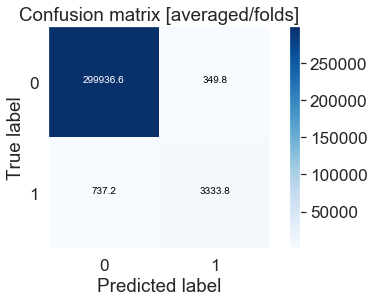

In [42]:
# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'Confusion matrix [averaged/folds]')

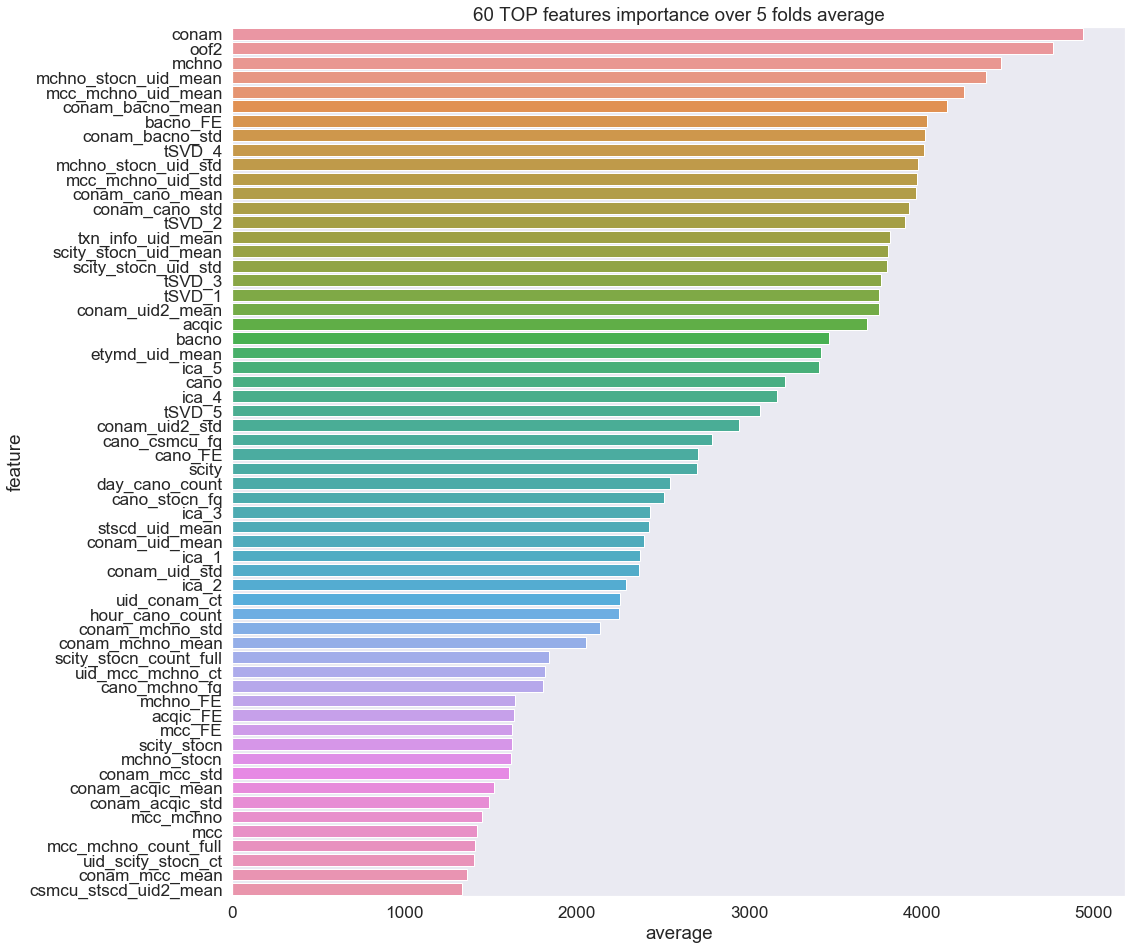

In [43]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(60), x='average', y='feature');
plt.title('60 TOP features importance over {} folds average'.format(folds.n_splits));

In [44]:
# Optimize f1 score
thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = f1_score(y.values, (y_oof > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

F1 score at threshold 0.1 is 0.8054037511476413
F1 score at threshold 0.11 is 0.812285328074102
F1 score at threshold 0.12 is 0.8180167253323768
F1 score at threshold 0.13 is 0.8236573266586632
F1 score at threshold 0.14 is 0.8276681286549707
F1 score at threshold 0.15 is 0.8312520160361274
F1 score at threshold 0.16 is 0.834619317653621
F1 score at threshold 0.17 is 0.8380252002435712
F1 score at threshold 0.18 is 0.8402843155714556
F1 score at threshold 0.19 is 0.8430272471178657
F1 score at threshold 0.2 is 0.8450791384029515
F1 score at threshold 0.21 is 0.8471252272075
F1 score at threshold 0.22 is 0.8487701767870868
F1 score at threshold 0.23 is 0.8498191463708705
F1 score at threshold 0.24 is 0.8509783029833398
F1 score at threshold 0.25 is 0.8522589116374069
F1 score at threshold 0.26 is 0.8536686607251861
F1 score at threshold 0.27 is 0.8550561246997695
F1 score at threshold 0.28 is 0.855842782300711
F1 score at threshold 0.29 is 0.8556403229390416
F1 score at threshold 0.3 is

In [48]:
sub = pd.read_csv('E-Sun_Credit_Card_Fraud_Data/submission_test.csv')
print('\tSuccessfully loaded sample_submission!')

#sub['fraud_ind'] = y_preds
#sub.to_csv("E-Sun_Credit_Card_Fraud_Detection_submission_stack.csv", index=False)

sub['fraud_ind'] = (y_preds_vote > 0.5).astype(int)
sub.to_csv("E-Sun_Credit_Card_Fraud_Detection_submission_stack_vote.csv", index=False)

	Successfully loaded sample_submission!


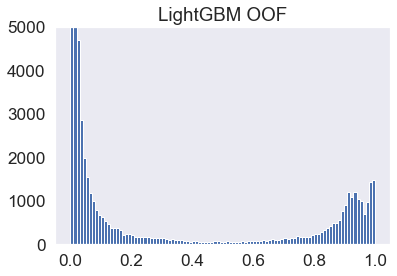

In [45]:
plt.hist(y_oof,bins=100)
plt.ylim((0,5000))
plt.title('LightGBM OOF')
plt.show()

X['oof'] = y_oof
X.reset_index(inplace=True)
X[['txkey','oof']].to_csv('oof_lifgtgbm_stack.csv')
X.set_index('txkey',drop=True,inplace=True)

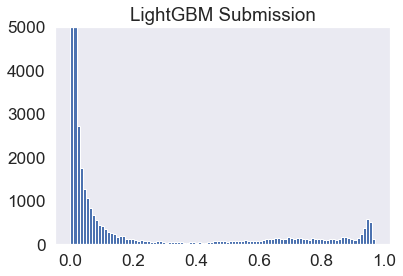

In [46]:
plt.hist(y_preds,bins=100)
plt.ylim((0,5000))
plt.title('LightGBM Submission')
plt.show()

In [ ]:
"""
----------------------------------------0.658867
Mean AUC = 0.9968150383854104
Out of folds AUC = 0.9966912490351028

Mean F1 Score = 0.8615584138372678
Mean Recall score = 0.8102460976566966
Mean Precision score = 0.9198906127114906
Wall time: 2h 47min 10s
----------------------------------------0.65333
Mean AUC = 0.9968365488287456
Out of folds AUC = 0.9967181716503462

Mean F1 Score = 0.8646759851254272
Mean Recall score = 0.8156291787875809
Mean Precision score = 0.9200742999403376
Wall time: 7h 8min 25s
---------------------------------------0.64
Mean AUC = 0.9964491541526675
Out of folds AUC = 0.9963266433414327

Mean F1 Score = 0.8590834181108133
Mean Recall score = 0.8087012542749383
Mean Precision score = 0.9162556220775253
Wall time: 4h 55min 9s
"""

In [ ]:
check_null_train = X.isnull().sum()
check_null_train[check_null_train>0].sort_values(ascending=False)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

SEED = 42
NFOLDS = 3
folds = KFold(n_splits=NFOLDS)
columns = [col for col in list(train)]
columns.remove('fraud_ind')
columns.remove('locdt')
splits = folds.split(train, train['fraud_ind'])
FEATURES = columns

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = train[columns].iloc[train_index], train[columns].iloc[valid_index]
    y_train, y_valid = train['fraud_ind'].iloc[train_index], train['fraud_ind'].iloc[valid_index]
    
    clf = lgb.LGBMClassifier(objective = 'binary',
                             boosting_type = 'gbdt',
                             eval_metric = "auc",
                             learning_rate =  0.007,
                             num_leaves = 2**8,
                             max_depth = -1,
                             tree_learner = 'serial',
                             colsample_bytree = 0.5,
                             subsample_freq = 1,
                             subsample = 0.7,
                             n_estimators=10000,
                             min_data_in_leaf = 106,
                             max_bin = 255,
                             random_state = SEED,
                             early_stopping_rounds = 100,
                            )


    clf.fit(X_train, 
            y_train,
            verbose=200, early_stopping_rounds=200, eval_metric = "auc",
            eval_set=[(X_valid, y_valid)])
    
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importances_
    
    permutation_importance = PermutationImportance(clf, random_state=SEED)
    permutation_importance.fit(X_valid, y_valid)
    print(f"Permutation importance for fold {fold_n+1}")
    display(eli5.show_weights(permutation_importance, feature_names = FEATURES, top=100))